In [1]:
!pip install -q timm mediapipe pillow-heif

import os
import json
import random
from pathlib import Path

import numpy as np
import pandas as pd

from PIL import Image
from pillow_heif import register_heif_opener

import cv2
import timm
import mediapipe as mp

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

register_heif_opener()  # supaya PIL bisa baca .heic/.heif

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 41.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 18.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Device: cuda


In [2]:
# ==========================
# PATH & GLOBAL CONFIG
# ==========================
DATA_DIR = "/kaggle/input/dataset-dl/Train"   # ganti kalau beda
WORK_DIR = "/kaggle/working/face_recognition"
os.makedirs(WORK_DIR, exist_ok=True)

VALID_EXTS = [".jpg", ".jpeg", ".png", ".webp", ".bmp", ".jfif", ".heic", ".heif"]

IMG_SIZE = 224

# ==========================
# HYPERPARAMETER DENSENET121 (CNN)
# ==========================
BATCH_SIZE = 32
NUM_WORKERS = 0

NUM_EPOCHS_DENSE = 25
LR_DENSE         = 1e-4
WEIGHT_DECAY_DENSE = 1e-4
LOSS_FN_DENSE    = "label_smoothing_ce"
LABEL_SMOOTHING_DENSE = 0.1
OPTIMIZER_DENSE  = "adamw"
PATIENCE_DENSE   = 5

# ==========================
# HYPERPARAMETER SWIN TINY (Transformer)
# (LOGIKA SAMA SEPERTI SEBELUMNYA)
# ==========================
NUM_EPOCHS_SWIN = 25
LR_SWIN         = 1e-4
WEIGHT_DECAY_SW = 1e-4
LOSS_FN_SWIN    = "label_smoothing_ce"
LABEL_SMOOTHING_SW = 0.1
OPTIMIZER_SWIN  = "adamw"
PATIENCE_SWIN   = 5

# ==========================
# SEED
# ==========================
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if device.type == "cuda":
    torch.cuda.manual_seed_all(RANDOM_SEED)

print("DATA_DIR:", DATA_DIR)
print("WORK_DIR:", WORK_DIR)
print("Device  :", device)


DATA_DIR: /kaggle/input/dataset-dl/Train
WORK_DIR: /kaggle/working/face_recognition
Device  : cuda


In [3]:
image_paths = []
labels_str = []

for class_name in sorted(os.listdir(DATA_DIR)):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        fpath = os.path.join(class_dir, fname)
        if not os.path.isfile(fpath):
            continue
        ext = os.path.splitext(fname)[1].lower()
        if ext in VALID_EXTS:
            image_paths.append(fpath)
            labels_str.append(class_name)

image_paths = np.array(image_paths)
labels_str  = np.array(labels_str)

print("Total gambar:", len(image_paths))
print("Contoh path :", image_paths[:3])
print("Contoh label:", labels_str[:3])

unique_classes = sorted(list(set(labels_str)))
class2idx = {c: i for i, c in enumerate(unique_classes)}
idx2class = {i: c for c, i in class2idx.items()}
num_classes = len(unique_classes)

labels = np.array([class2idx[s] for s in labels_str], dtype=np.int64)

print("Total kelas:", num_classes)
print("Contoh mapping:", list(class2idx.items())[:5])

label_mapping_path = os.path.join(WORK_DIR, "label_mapping.json")
with open(label_mapping_path, "w") as f:
    json.dump({"class2idx": class2idx, "idx2class": idx2class}, f, indent=2)
print("Label mapping disimpan di:", label_mapping_path)


Total gambar: 284
Contoh path : ['/kaggle/input/dataset-dl/Train/ Nasya Aulia Efendi/temp_image_5BD313DA-028B-4E44-92B4-98405A6C90DA - NASYA AULIA EFENDI.webp'
 '/kaggle/input/dataset-dl/Train/ Nasya Aulia Efendi/11C29E23-C85C-4FF2-8785-B284C339A87F - NASYA AULIA EFENDI.jpeg'
 '/kaggle/input/dataset-dl/Train/ Nasya Aulia Efendi/IMG_6753 - NASYA AULIA EFENDI.jpeg']
Contoh label: [' Nasya Aulia Efendi' ' Nasya Aulia Efendi' ' Nasya Aulia Efendi']
Total kelas: 70
Contoh mapping: [(' Nasya Aulia Efendi', 0), ('Abraham Ganda Napitu', 1), ('Abu Bakar Siddiq Siregar', 2), ('Ahmad Faqih Hasani', 3), ('Aldi Sanjaya', 4)]
Label mapping disimpan di: /kaggle/working/face_recognition/label_mapping.json


In [4]:
rng = np.random.default_rng(RANDOM_SEED)

train_paths, train_labels = [], []
val_paths, val_labels = [], []

for c in range(num_classes):
    idxs = np.where(labels == c)[0]
    if len(idxs) == 0:
        continue
    rng.shuffle(idxs)

    val_idx = idxs[0]
    train_idx = idxs[1:]

    val_paths.append(image_paths[val_idx])
    val_labels.append(labels[val_idx])

    for tid in train_idx:
        train_paths.append(image_paths[tid])
        train_labels.append(labels[tid])

train_paths = np.array(train_paths)
train_labels = np.array(train_labels, dtype=np.int64)
val_paths   = np.array(val_paths)
val_labels  = np.array(val_labels, dtype=np.int64)

print("Train images:", len(train_paths))
print("Val images  :", len(val_paths))


Train images: 214
Val images  : 70


In [5]:
mp_face_detection = mp.solutions.face_detection

def read_image_bgr(path):
    ext = os.path.splitext(path)[1].lower()
    if ext in [".heic", ".heif"]:
        img = Image.open(path).convert("RGB")
        img = np.array(img)[:, :, ::-1]  # RGB -> BGR
        return img
    img = cv2.imread(path)
    if img is None:
        img_pil = Image.open(path).convert("RGB")
        img = np.array(img_pil)[:, :, ::-1]
    return img


def crop_face_mediapipe(path, margin=0.2):
    img_bgr = read_image_bgr(path)
    h, w, _ = img_bgr.shape
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    with mp_face_detection.FaceDetection(
        model_selection=1,
        min_detection_confidence=0.5
    ) as face_det:
        results = face_det.process(img_rgb)

        if not results.detections:
            # fallback: pakai full image
            return Image.fromarray(img_rgb)

        detections = sorted(
            results.detections,
            key=lambda d: d.score[0] if d.score else 0,
            reverse=True
        )
        det = detections[0]
        bbox = det.location_data.relative_bounding_box

        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h)
        box_w = int(bbox.width * w)
        box_h = int(bbox.height * h)

        cx = x_min + box_w // 2
        cy = y_min + box_h // 2

        half_w = int(box_w * (1 + margin) / 2)
        half_h = int(box_h * (1 + margin) / 2)

        x1 = max(0, cx - half_w)
        x2 = min(w, cx + half_w)
        y1 = max(0, cy - half_h)
        y2 = min(h, cy + half_h)

        crop = img_rgb[y1:y2, x1:x2]
        if crop.size == 0:
            return Image.fromarray(img_rgb)

        return Image.fromarray(crop)


In [6]:
def compute_metrics(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1

    acc = np.trace(cm) / np.sum(cm)

    precision_per_class = []
    recall_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        tp = cm[c, c]
        fp = cm[:, c].sum() - tp
        fn = cm[c, :].sum() - tp

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0

        precision_per_class.append(prec)
        recall_per_class.append(rec)
        f1_per_class.append(f1)

    precision_per_class = np.array(precision_per_class)
    recall_per_class    = np.array(recall_per_class)
    f1_per_class        = np.array(f1_per_class)

    support = cm.sum(axis=1)
    total = support.sum()
    weights = support / total

    precision_weighted = np.sum(precision_per_class * weights)
    recall_weighted    = np.sum(recall_per_class * weights)
    f1_weighted        = np.sum(f1_per_class * weights)

    return {
        "confusion_matrix": cm,
        "accuracy": acc,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
    }


def plot_history(history, title=""):
    epochs = range(1, len(history["train_loss"]) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} Accuracy")
    plt.legend()

    plt.show()


In [7]:
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])


class FaceDataset(Dataset):
    def __init__(self, paths, labels, transform=None, use_face_crop=True):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.use_face_crop = use_face_crop

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        if self.use_face_crop:
            img_pil = crop_face_mediapipe(path)
        else:
            img_bgr = read_image_bgr(path)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)

        if self.transform is not None:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = T.ToTensor()(img_pil)

        return img_tensor, label


train_dataset = FaceDataset(
    train_paths, train_labels,
    transform=train_transform,
    use_face_crop=True
)
val_dataset = FaceDataset(
    val_paths, val_labels,
    transform=val_transform,
    use_face_crop=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print("Train batches:", len(train_loader))
print("Val batches  :", len(val_loader))


Train batches: 7
Val batches  : 3


In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        log_probs = torch.log_softmax(pred, dim=-1)
        n_classes = pred.size(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))


def get_criterion(loss_name: str, smoothing: float = 0.1):
    loss_name = loss_name.lower()
    if loss_name == "label_smoothing_ce":
        return LabelSmoothingCrossEntropy(smoothing=smoothing).to(device)
    elif loss_name == "cross_entropy":
        return nn.CrossEntropyLoss().to(device)
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")


def get_optimizer(model, optimizer_name: str, lr: float, weight_decay: float = 0.0):
    optimizer_name = optimizer_name.lower()
    params = model.parameters()

    if optimizer_name == "adamw":
        return torch.optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "sgd":
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    return avg_loss, avg_acc


def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_true, all_pred = [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += imgs.size(0)

            all_true.extend(labels.cpu().numpy().tolist())
            all_pred.extend(preds.cpu().numpy().tolist())

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    return avg_loss, avg_acc, all_true, all_pred


In [9]:
def build_densenet121(num_classes):
    model = timm.create_model(
        "densenet121",
        pretrained=True,
        num_classes=num_classes
    )
    return model

densenet_model = build_densenet121(num_classes).to(device)
print("DenseNet121 params (M):", sum(p.numel() for p in densenet_model.parameters())/1e6)


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

DenseNet121 params (M): 7.025606


In [10]:
criterion_dense = get_criterion(
    LOSS_FN_DENSE,
    smoothing=LABEL_SMOOTHING_DENSE
)

optimizer_dense = get_optimizer(
    densenet_model,
    optimizer_name=OPTIMIZER_DENSE,
    lr=LR_DENSE,
    weight_decay=WEIGHT_DECAY_DENSE
)

history_dense = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

best_val_acc_dense = 0.0
best_state_dense = None
patience_counter = 0

print("===== Training DenseNet121 (CNN) =====")
for epoch in range(1, NUM_EPOCHS_DENSE + 1):
    train_loss, train_acc = train_one_epoch(
        densenet_model, train_loader, optimizer_dense, criterion_dense, device
    )
    val_loss, val_acc, y_true_dense, y_pred_dense = evaluate_model(
        densenet_model, val_loader, criterion_dense, device
    )

    history_dense["train_loss"].append(train_loss)
    history_dense["val_loss"].append(val_loss)
    history_dense["train_acc"].append(train_acc)
    history_dense["val_acc"].append(val_acc)

    print(
        f"[Epoch {epoch}/{NUM_EPOCHS_DENSE}] "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, "
        f"best_val_acc={best_val_acc_dense:.4f}, patience={patience_counter}"
    )

    if val_acc > best_val_acc_dense:
        best_val_acc_dense = val_acc
        best_state_dense = densenet_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE_DENSE:
        print("Early stopping DenseNet.")
        break

if best_state_dense is not None:
    densenet_model.load_state_dict(best_state_dense)

===== Training DenseNet121 (CNN) =====


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764559209.715231     151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559209.934706     155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559210.096611     159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559210.155006     163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559210.307756     167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559210.529123     

[Epoch 1/25] train_loss=4.3112, val_loss=4.2408, train_acc=0.0234, val_acc=0.0286, best_val_acc=0.0000, patience=0


W0000 00:00:1764559256.351178    1694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559256.406381    1698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559256.473512    1702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559256.979518    1802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559257.141596    1806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559257.388935    1810 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 2/25] train_loss=4.0720, val_loss=4.1672, train_acc=0.1028, val_acc=0.0857, best_val_acc=0.0286, patience=0


W0000 00:00:1764559298.791806    3236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559298.912633    3240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559299.036017    3244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559299.129454    3249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559299.164708    3254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559299.207436    3258 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 3/25] train_loss=3.9157, val_loss=4.0415, train_acc=0.1729, val_acc=0.1000, best_val_acc=0.0857, patience=0


W0000 00:00:1764559340.536659    4779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559341.125002    4878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559341.206249    4881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559341.247683    4885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559341.316276    4891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559341.489559    4894 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 4/25] train_loss=3.7060, val_loss=3.9351, train_acc=0.2804, val_acc=0.2143, best_val_acc=0.1000, patience=0


W0000 00:00:1764559382.979331    6320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559383.193221    6325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559383.355575    6328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559383.577698    6332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559383.793876    6336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559383.865102    6339 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 5/25] train_loss=3.5108, val_loss=3.8173, train_acc=0.4720, val_acc=0.2857, best_val_acc=0.2143, patience=0


W0000 00:00:1764559424.594180    7866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559424.695262    7869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559424.747518    7874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559424.854718    7878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559425.101830    7882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559425.393928    7886 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 6/25] train_loss=3.2823, val_loss=3.7243, train_acc=0.6729, val_acc=0.3429, best_val_acc=0.2857, patience=0


W0000 00:00:1764559466.773528    9408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559466.864861    9412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559466.983076    9416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559467.110197    9419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559467.255832    9424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559467.418229    9427 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 7/25] train_loss=3.1127, val_loss=3.5928, train_acc=0.7710, val_acc=0.3857, best_val_acc=0.3429, patience=0


W0000 00:00:1764559508.869540   10950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559509.112230   10953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559509.263573   10957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559509.396653   10962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559509.453083   10965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559509.503507   10970 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 8/25] train_loss=2.9183, val_loss=3.4483, train_acc=0.8738, val_acc=0.5286, best_val_acc=0.3857, patience=0


W0000 00:00:1764559551.111375   12491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559551.439699   12496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559551.533300   12499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559551.620586   12504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559551.839938   12509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559552.011179   12512 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 9/25] train_loss=2.7365, val_loss=3.3137, train_acc=0.9252, val_acc=0.5857, best_val_acc=0.5286, patience=0


W0000 00:00:1764559593.176292   14034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559593.233968   14038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559593.278230   14041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559593.530477   14045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559593.806159   14049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559594.154546   14055 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 10/25] train_loss=2.5556, val_loss=3.1717, train_acc=0.9579, val_acc=0.6000, best_val_acc=0.5857, patience=0


W0000 00:00:1764559635.038879   15571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559635.179483   15577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559635.310029   15598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559635.405545   15603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559635.518458   15607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559635.594424   15611 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 11/25] train_loss=2.3825, val_loss=3.0331, train_acc=0.9673, val_acc=0.6286, best_val_acc=0.6000, patience=0


W0000 00:00:1764559677.487964   17120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559677.612399   17121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559677.717329   17125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559677.827715   17129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559677.980727   17134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559678.092167   17137 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 12/25] train_loss=2.1950, val_loss=2.9189, train_acc=0.9720, val_acc=0.6286, best_val_acc=0.6286, patience=0


W0000 00:00:1764559719.760452   18656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559719.937056   18662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559720.087408   18663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559720.295265   18668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559720.542069   18671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559720.700137   18676 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 13/25] train_loss=1.9924, val_loss=2.8152, train_acc=0.9766, val_acc=0.5857, best_val_acc=0.6286, patience=1


W0000 00:00:1764559761.473024   20198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559761.661995   20202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559761.754176   20205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559761.883433   20209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559762.035011   20213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559762.187397   20218 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 14/25] train_loss=1.8527, val_loss=2.7019, train_acc=0.9907, val_acc=0.6286, best_val_acc=0.6286, patience=2


W0000 00:00:1764559803.261301   21743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559803.395384   21747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559803.546393   21752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559803.695062   21756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559803.920351   21759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559804.161680   21764 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 15/25] train_loss=1.7360, val_loss=2.6050, train_acc=1.0000, val_acc=0.6571, best_val_acc=0.6286, patience=3


W0000 00:00:1764559845.260732   23282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559845.388084   23285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559845.857219   23386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559846.039551   23390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559846.171473   23393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559846.251320   23397 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 16/25] train_loss=1.5989, val_loss=2.4969, train_acc=0.9953, val_acc=0.6714, best_val_acc=0.6571, patience=0


W0000 00:00:1764559887.014942   24823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559887.194377   24828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559887.464283   24831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559887.681800   24836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559887.807575   24839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559887.972950   24843 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 17/25] train_loss=1.4748, val_loss=2.4131, train_acc=1.0000, val_acc=0.6571, best_val_acc=0.6714, patience=0


W0000 00:00:1764559929.103798   26366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559929.196020   26370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559929.361968   26374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559929.593127   26377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559929.713041   26382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559929.883684   26404 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 18/25] train_loss=1.3387, val_loss=2.3401, train_acc=1.0000, val_acc=0.6714, best_val_acc=0.6714, patience=1


W0000 00:00:1764559971.020541   27909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559971.235488   27912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559971.306196   27916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559971.371925   27919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559971.479010   27924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764559971.797906   27928 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 19/25] train_loss=1.2884, val_loss=2.2852, train_acc=0.9907, val_acc=0.6714, best_val_acc=0.6714, patience=2


W0000 00:00:1764560012.558525   29450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560012.650105   29453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560012.830901   29457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560013.032346   29462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560013.191684   29467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560013.310796   29470 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 20/25] train_loss=1.2126, val_loss=2.2207, train_acc=1.0000, val_acc=0.6857, best_val_acc=0.6714, patience=3


W0000 00:00:1764560054.577775   30998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560054.685321   31000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560054.973961   31004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560055.125637   31008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560055.275844   31013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560055.453543   31016 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 21/25] train_loss=1.1176, val_loss=2.1580, train_acc=1.0000, val_acc=0.7143, best_val_acc=0.6857, patience=0


W0000 00:00:1764560097.661171   32535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560097.885954   32538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560097.960196   32541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560098.072277   32545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560098.311304   32549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560098.558123   32554 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 22/25] train_loss=1.0877, val_loss=2.0987, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7143, patience=0


W0000 00:00:1764560140.296423   34079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560140.343681   34084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560140.405496   34087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560140.549281   34093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560140.787888   34096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560140.910279   34101 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 23/25] train_loss=1.0258, val_loss=2.0710, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7286, patience=0


W0000 00:00:1764560182.519530   35621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560182.568088   35625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560182.616889   35631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560182.734444   35633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560183.046448   35637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560183.341911   35642 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 24/25] train_loss=0.9898, val_loss=2.0206, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7286, patience=1


W0000 00:00:1764560224.430783   37167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560224.495848   37171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560224.662368   37176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560224.784215   37179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560224.857853   37183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560225.013574   37188 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 25/25] train_loss=0.9480, val_loss=1.9957, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7286, patience=2


W0000 00:00:1764560266.442991   38689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560266.493139   38696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560266.536022   38697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


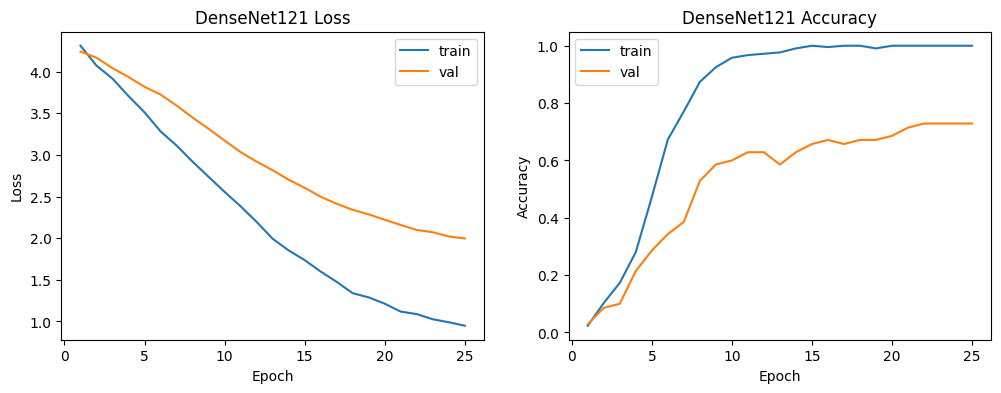

W0000 00:00:1764560266.980756   38704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560267.073788   38708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560267.172408   38711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560267.288674   38715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560267.477849   38719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560267.628304   38722 inference_feedback_manager.cc:114] Feedback manager 

In [11]:
plot_history(history_dense, title="DenseNet121")

val_loss_best_dense, val_acc_best_dense, y_true_dense_best, y_pred_dense_best = evaluate_model(
    densenet_model, val_loader, criterion_dense, device
)

metrics_dense = compute_metrics(y_true_dense_best, y_pred_dense_best, num_classes)


=== DenseNet121 Metrics (weighted, BEST CHECKPOINT) ===
Accuracy : 0.7286
Precision: 0.6452
Recall   : 0.7286
F1-score : 0.6714


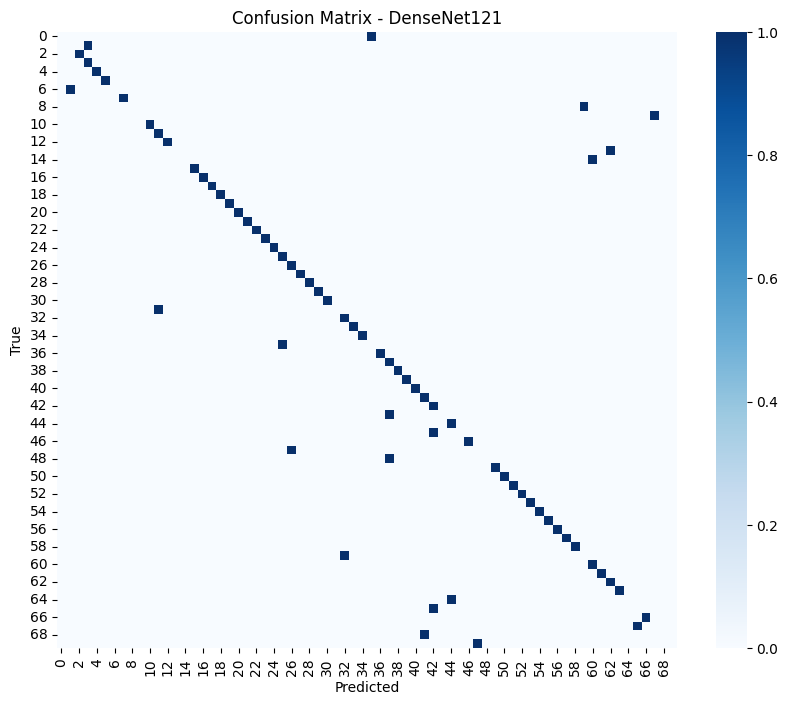

In [12]:
print("\n=== DenseNet121 Metrics (weighted, BEST CHECKPOINT) ===")
print(f"Accuracy : {metrics_dense['accuracy']:.4f}")
print(f"Precision: {metrics_dense['precision_weighted']:.4f}")
print(f"Recall   : {metrics_dense['recall_weighted']:.4f}")
print(f"F1-score : {metrics_dense['f1_weighted']:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_dense["confusion_matrix"], cmap="Blues")
plt.title("Confusion Matrix - DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [13]:
def build_swin_tiny(num_classes):
    model = timm.create_model(
        "swin_tiny_patch4_window7_224",
        pretrained=True,
        num_classes=num_classes
    )
    return model

swin_model = build_swin_tiny(num_classes).to(device)
print("Swin Tiny params (M):", sum(p.numel() for p in swin_model.parameters())/1e6)


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin Tiny params (M): 27.573184


In [14]:
criterion_swin = get_criterion(
    LOSS_FN_SWIN,
    smoothing=LABEL_SMOOTHING_SW
)

optimizer_swin = get_optimizer(
    swin_model,
    optimizer_name=OPTIMIZER_SWIN,
    lr=LR_SWIN,
    weight_decay=WEIGHT_DECAY_SW
)

history_swin = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

best_val_acc_swin = 0.0
best_state_swin = None
patience_counter = 0

print("===== Training Swin Tiny (Transformer) =====")
for epoch in range(1, NUM_EPOCHS_SWIN + 1):
    train_loss, train_acc = train_one_epoch(
        swin_model, train_loader, optimizer_swin, criterion_swin, device
    )
    val_loss, val_acc, y_true_swin, y_pred_swin = evaluate_model(
        swin_model, val_loader, criterion_swin, device
    )

    history_swin["train_loss"].append(train_loss)
    history_swin["val_loss"].append(val_loss)
    history_swin["train_acc"].append(train_acc)
    history_swin["val_acc"].append(val_acc)

    print(
        f"[Epoch {epoch}/{NUM_EPOCHS_SWIN}] "
        f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
        f"train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, "
        f"best_val_acc={best_val_acc_swin:.4f}, patience={patience_counter}"
    )

    if val_acc > best_val_acc_swin:
        best_val_acc_swin = val_acc
        best_state_swin = swin_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE_SWIN:
        print("Early stopping Swin.")
        break

if best_state_swin is not None:
    swin_model.load_state_dict(best_state_swin)

===== Training Swin Tiny (Transformer) =====


W0000 00:00:1764560278.923754   39088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560279.176538   39092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560279.301980   39096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560279.436069   39099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560279.572921   39104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560279.777588   39108 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 1/25] train_loss=4.2888, val_loss=4.1875, train_acc=0.0187, val_acc=0.0857, best_val_acc=0.0000, patience=0


W0000 00:00:1764560321.685307   40637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560321.833378   40641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560321.916517   40644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560322.023703   40649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560322.158919   40653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560322.335380   40658 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 2/25] train_loss=4.0608, val_loss=3.8717, train_acc=0.0794, val_acc=0.1286, best_val_acc=0.0857, patience=0


W0000 00:00:1764560365.101336   42179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560365.216935   42184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560365.392530   42186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560365.583463   42191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560365.671498   42194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560365.754054   42199 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 3/25] train_loss=3.5562, val_loss=3.3529, train_acc=0.2523, val_acc=0.3429, best_val_acc=0.1286, patience=0


W0000 00:00:1764560408.730852   43716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560408.971251   43720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560409.094218   43726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560409.140581   43729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560409.185380   43734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560409.446921   43737 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 4/25] train_loss=2.8662, val_loss=2.7861, train_acc=0.5327, val_acc=0.5143, best_val_acc=0.3429, patience=0


W0000 00:00:1764560452.065640   45258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560452.277338   45263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560452.468595   45267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560452.633149   45270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560452.894866   45275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560452.985611   45278 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 5/25] train_loss=2.1231, val_loss=2.3628, train_acc=0.8037, val_acc=0.5857, best_val_acc=0.5143, patience=0


W0000 00:00:1764560495.243513   46809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560495.426332   46812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560495.561374   46816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560495.609157   46820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560495.727170   46825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560495.891501   46829 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 6/25] train_loss=1.5629, val_loss=2.2030, train_acc=0.9019, val_acc=0.6429, best_val_acc=0.5857, patience=0


W0000 00:00:1764560538.259907   48347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560538.529738   48352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560538.780567   48355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560538.926659   48359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560538.971596   48362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560539.174764   48366 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 7/25] train_loss=1.2629, val_loss=2.0049, train_acc=0.9346, val_acc=0.6571, best_val_acc=0.6429, patience=0


W0000 00:00:1764560581.369691   49885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560581.553364   49889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560581.673266   49893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560581.794487   49897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560582.074741   49901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560582.212308   49904 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 8/25] train_loss=1.1263, val_loss=1.8760, train_acc=0.9673, val_acc=0.7000, best_val_acc=0.6571, patience=0


W0000 00:00:1764560624.673635   51432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560624.923460   51437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560624.994232   51440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560625.215776   51442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560625.439603   51447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560625.480189   51450 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 9/25] train_loss=1.0097, val_loss=1.8488, train_acc=0.9813, val_acc=0.6714, best_val_acc=0.7000, patience=0


W0000 00:00:1764560667.687831   52973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560667.782851   52977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560668.116492   52983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560668.280158   52984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560668.486848   52990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560668.755573   52994 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 10/25] train_loss=0.9525, val_loss=1.9073, train_acc=0.9907, val_acc=0.6714, best_val_acc=0.7000, patience=1


W0000 00:00:1764560710.492343   54515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560710.645234   54518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560710.921642   54522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560711.098448   54527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560711.278699   54530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560711.379830   54534 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 11/25] train_loss=0.9210, val_loss=1.8829, train_acc=1.0000, val_acc=0.7000, best_val_acc=0.7000, patience=2


W0000 00:00:1764560753.701323   56053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560753.863573   56057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560753.999660   56079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560754.083262   56083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560754.210779   56087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560754.388857   56093 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 12/25] train_loss=0.9276, val_loss=1.8819, train_acc=0.9907, val_acc=0.7143, best_val_acc=0.7000, patience=3


W0000 00:00:1764560796.583580   57598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560796.629805   57603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560796.672665   57606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560796.859721   57611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560796.943007   57614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560796.997142   57620 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 13/25] train_loss=0.8839, val_loss=1.8765, train_acc=1.0000, val_acc=0.7143, best_val_acc=0.7143, patience=0


W0000 00:00:1764560839.729488   59140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560839.800928   59144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560839.864044   59148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560840.056728   59152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560840.247932   59156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560840.428165   59161 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 14/25] train_loss=0.8790, val_loss=1.8555, train_acc=0.9953, val_acc=0.6857, best_val_acc=0.7143, patience=1


W0000 00:00:1764560883.192789   60686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560883.243403   60690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560883.285876   60694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560883.333601   60698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560883.480492   60703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560883.699548   60708 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 15/25] train_loss=0.8742, val_loss=1.8439, train_acc=0.9953, val_acc=0.7143, best_val_acc=0.7143, patience=2


W0000 00:00:1764560926.621727   62225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560926.672871   62228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560926.728660   62234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560926.775236   62236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560926.861284   62241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560927.007276   62246 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 16/25] train_loss=0.8694, val_loss=1.8434, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7143, patience=3


W0000 00:00:1764560969.821526   63763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560969.982148   63767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560970.054643   63772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560970.119268   63774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560970.169525   63778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764560970.764841   63879 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 17/25] train_loss=0.8665, val_loss=1.8438, train_acc=1.0000, val_acc=0.7286, best_val_acc=0.7286, patience=0


W0000 00:00:1764561013.490741   65304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561013.805606   65309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561014.035682   65315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561014.288198   65316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561014.501251   65320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561014.686949   65326 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 18/25] train_loss=0.8529, val_loss=1.8511, train_acc=0.9953, val_acc=0.7000, best_val_acc=0.7286, patience=1


W0000 00:00:1764561056.441091   66854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561056.612765   66859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561056.805293   66865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561056.907546   66866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561057.073795   66870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561057.180561   66876 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 19/25] train_loss=0.8441, val_loss=1.8386, train_acc=1.0000, val_acc=0.7000, best_val_acc=0.7286, patience=2


W0000 00:00:1764561100.001818   68392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561100.198114   68396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561100.286265   68400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561100.399841   68404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561100.516584   68408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561100.612646   68412 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 20/25] train_loss=0.8578, val_loss=1.8526, train_acc=0.9953, val_acc=0.7143, best_val_acc=0.7286, patience=3


W0000 00:00:1764561142.641265   69931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561142.900622   69936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561143.112308   69940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561143.168912   69943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561143.225710   69946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561143.409901   69951 inference_feedback_manager.cc:114] Feedback manager 

[Epoch 21/25] train_loss=0.8258, val_loss=1.9017, train_acc=1.0000, val_acc=0.7000, best_val_acc=0.7286, patience=4
Early stopping Swin.


W0000 00:00:1764561185.090696   71460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561185.140226   71464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561185.181203   71469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


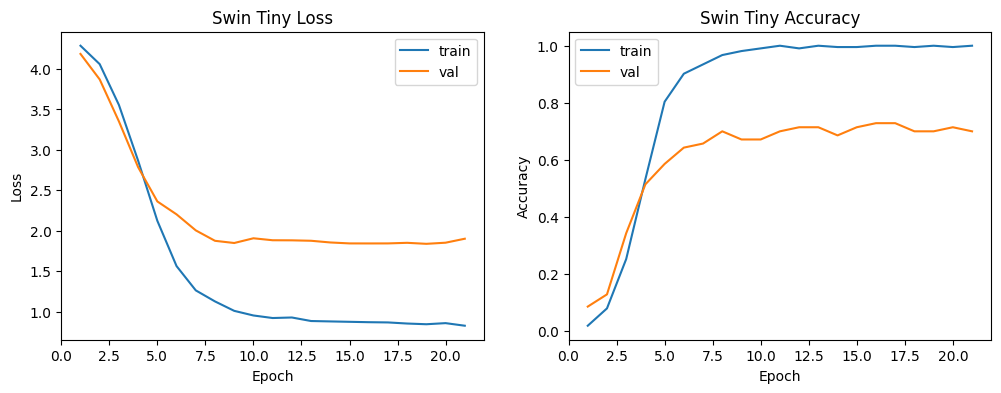

W0000 00:00:1764561185.598384   71473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561185.689326   71478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561185.790735   71481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561185.931402   71486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561186.105930   71489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561186.266605   71494 inference_feedback_manager.cc:114] Feedback manager 


Val accuracy (best checkpoint, re-eval): 0.7000


W0000 00:00:1764561194.912957   71838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561194.966522   71844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764561195.009687   71847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [15]:
plot_history(history_swin, title="Swin Tiny")

val_loss_best_swin, val_acc_best_swin, y_true_swin_best, y_pred_swin_best = evaluate_model(
    swin_model, val_loader, criterion_swin, device
)

print(f"\nVal accuracy (best checkpoint, re-eval): {val_acc_best_swin:.4f}")

metrics_swin = compute_metrics(y_true_swin_best, y_pred_swin_best, num_classes)



=== Swin Tiny Metrics (weighted, BEST CHECKPOINT) ===
Accuracy : 0.7000
Precision: 0.6048
Recall   : 0.7000
F1-score : 0.6333


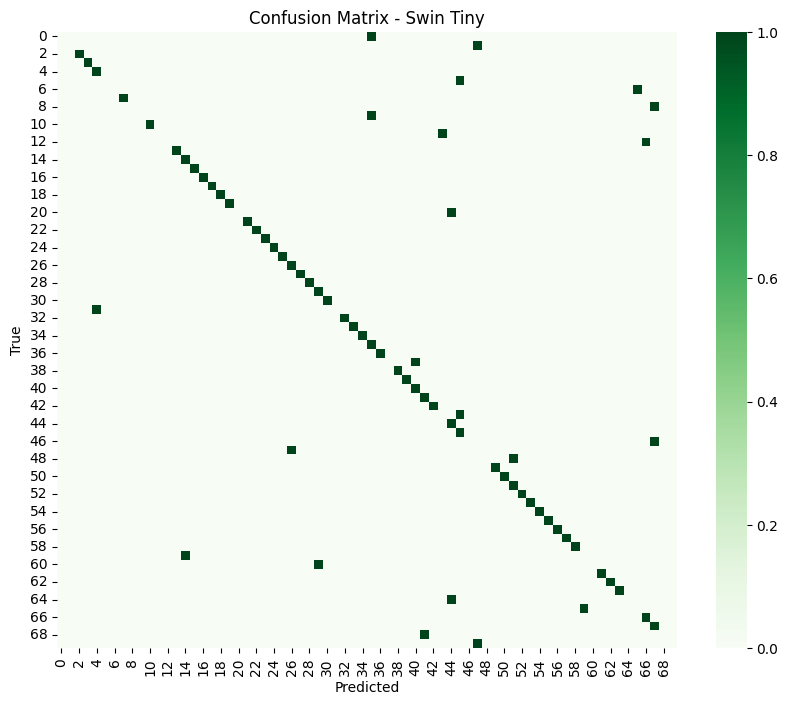

In [16]:
print("\n=== Swin Tiny Metrics (weighted, BEST CHECKPOINT) ===")
print(f"Accuracy : {metrics_swin['accuracy']:.4f}")
print(f"Precision: {metrics_swin['precision_weighted']:.4f}")
print(f"Recall   : {metrics_swin['recall_weighted']:.4f}")
print(f"F1-score : {metrics_swin['f1_weighted']:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(metrics_swin["confusion_matrix"], cmap="Greens")
plt.title("Confusion Matrix - Swin Tiny")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [17]:
acc_dense = metrics_dense["accuracy"]
acc_swin  = metrics_swin["accuracy"]

if acc_dense >= acc_swin:
    selected_model = "densenet"
else:
    selected_model = "swin"

print("Accuracy DenseNet121:", acc_dense)
print("Accuracy Swin Tiny  :", acc_swin)
print("Model terpilih      :", selected_model)

dense_weights_path = os.path.join(WORK_DIR, "densenet121_facecls.pth")
swin_weights_path  = os.path.join(WORK_DIR, "swin_tiny_facecls.pth")

torch.save(densenet_model.state_dict(), dense_weights_path)
torch.save(swin_model.state_dict(), swin_weights_path)

print("Saved DenseNet121 weights:", dense_weights_path)
print("Saved Swin Tiny weights :", swin_weights_path)
print("Label mapping path      :", label_mapping_path)

config = {
    "num_classes": num_classes,
    "class_names": unique_classes,
    "selected_model": selected_model,
    "densenet_model_name": "densenet121",
    "densenet_weights_file": os.path.basename(dense_weights_path),
    "swin_model_name": "swin_tiny_patch4_window7_224",
    "swin_weights_file": os.path.basename(swin_weights_path),
    "label_mapping_file": os.path.basename(label_mapping_path),
    "img_size": IMG_SIZE,
    "note": "selected_model = model terbaik (DenseNet / Swin) untuk inferensi & deploy."
}

config_path = os.path.join(WORK_DIR, "config_models.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=2)

print("Config disimpan di:", config_path)


Accuracy DenseNet121: 0.7285714285714285
Accuracy Swin Tiny  : 0.7
Model terpilih      : densenet
Saved DenseNet121 weights: /kaggle/working/face_recognition/densenet121_facecls.pth
Saved Swin Tiny weights : /kaggle/working/face_recognition/swin_tiny_facecls.pth
Label mapping path      : /kaggle/working/face_recognition/label_mapping.json
Config disimpan di: /kaggle/working/face_recognition/config_models.json


In [18]:
def infer_single_dense(path, model, transform, device):
    model.eval()
    with torch.no_grad():
        img_pil = crop_face_mediapipe(path)
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)[0]
        conf, idx = torch.max(probs, dim=0)
        return idx.item(), conf.item()


def infer_single_swin(path, model, transform, device):
    model.eval()
    with torch.no_grad():
        img_pil = crop_face_mediapipe(path)
        img_tensor = transform(img_pil).unsqueeze(0).to(device)
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)[0]
        conf, idx = torch.max(probs, dim=0)
        return idx.item(), conf.item()


def predict_hidden_best(
    folder_path,
    dense_model,
    swin_model,
    selected_model,
    device,
    csv_name="predictions_hidden_best.csv"
):
    filenames = []
    preds = []
    confs = []

    for fname in sorted(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        if not os.path.isfile(fpath):
            continue
        ext = os.path.splitext(fname)[1].lower()
        if ext not in VALID_EXTS:
            continue

        try:
            if selected_model == "densenet":
                idx, conf = infer_single_dense(fpath, dense_model, val_transform, device)
            else:
                idx, conf = infer_single_swin(fpath, swin_model, val_transform, device)

            filenames.append(fname)
            preds.append(idx2class[idx])
            confs.append(conf)
        except Exception as e:
            print("Skip:", fpath, "error:", e)

    df = pd.DataFrame({
        "filename": filenames,
        "pred_label": preds,
        "confidence": confs,
        "model_used": [selected_model] * len(filenames),
    })

    out_path = os.path.join(WORK_DIR, csv_name)
    df.to_csv(out_path, index=False)
    print("Saved hidden test predictions (best model only) to:", out_path)
    return df

# Contoh pemakaian (COMMENT kalau belum ada folder hidden test):
# HIDDEN_TEST_DIR = "/kaggle/input/hidden-test"
# df_hidden_best = predict_hidden_best(
#     folder_path=HIDDEN_TEST_DIR,
#     dense_model=densenet_model,
#     swin_model=swin_model,
#     selected_model=selected_model,
#     device=device,
#     csv_name="predictions_hidden_best.csv"
# )
# df_hidden_best.head()


In [19]:
# ============================================================
# Generate file untuk Hugging Face Spaces:
#   - app.py
#   - requirements.txt
#   - classes.json
#   (config_models.json & label_mapping.json & *.pth sudah dibuat sebelumnya)
# ============================================================

app_py_path = os.path.join(WORK_DIR, "app.py")
requirements_path = os.path.join(WORK_DIR, "requirements.txt")
classes_json_path = os.path.join(WORK_DIR, "classes.json")

# ----- classes.json (list nama kelas sesuai urutan training) -----
with open(classes_json_path, "w", encoding="utf-8") as f:
    json.dump(list(unique_classes), f, indent=2, ensure_ascii=False)
print("Saved classes.json ->", classes_json_path)

# ----- app.py -----
app_code = r'''import os
import json
import io

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as T
import timm
import mediapipe as mp

import streamlit as st


# ===============================
# Util: load config & classes
# ===============================

@st.cache_resource
def load_config_and_classes():
    with open("config_models.json", "r", encoding="utf-8") as f:
        config = json.load(f)

    # kalau ada classes.json pakai itu, kalau tidak pakai dari config
    class_names = None
    if os.path.exists("classes.json"):
        with open("classes.json", "r", encoding="utf-8") as f:
            data = json.load(f)
            # bisa list langsung atau dict {"classes": [...]}
            if isinstance(data, dict) and "classes" in data:
                class_names = data["classes"]
            else:
                class_names = data
    else:
        class_names = config.get("class_names", [])

    idx2class = {i: name for i, name in enumerate(class_names)}

    return config, class_names, idx2class


# ===============================
# Face crop (MediaPipe)
# ===============================

mp_face_detection = mp.solutions.face_detection

def crop_face_mediapipe_pil(pil_img, margin=0.2):
    """Crop wajah dari PIL.Image menggunakan MediaPipe. 
    Jika gagal, kembalikan full image."""
    img_rgb = np.array(pil_img)
    if img_rgb.ndim == 2:  # grayscale
        img_rgb = np.stack([img_rgb]*3, axis=-1)
    h, w, _ = img_rgb.shape

    with mp_face_detection.FaceDetection(
        model_selection=1,
        min_detection_confidence=0.5
    ) as face_det:
        results = face_det.process(img_rgb)

        if not results.detections:
            return pil_img

        detections = sorted(
            results.detections,
            key=lambda d: d.score[0] if d.score else 0,
            reverse=True
        )
        det = detections[0]
        bbox = det.location_data.relative_bounding_box

        x_min = int(bbox.xmin * w)
        y_min = int(bbox.ymin * h)
        box_w = int(bbox.width * w)
        box_h = int(bbox.height * h)

        cx = x_min + box_w // 2
        cy = y_min + box_h // 2

        half_w = int(box_w * (1 + margin) / 2)
        half_h = int(box_h * (1 + margin) / 2)

        x1 = max(0, cx - half_w)
        x2 = min(w, cx + half_w)
        y1 = max(0, cy - half_h)
        y2 = min(h, cy + half_h)

        crop = img_rgb[y1:y2, x1:x2]
        if crop.size == 0:
            return pil_img

        return Image.fromarray(crop)


# ===============================
# Build models (sama dengan training)
# ===============================

def build_densenet121(num_classes):
    model = timm.create_model(
        "densenet121",
        pretrained=False,
        num_classes=num_classes
    )
    in_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    return model


def build_swin_tiny(num_classes):
    model = timm.create_model(
        "swin_tiny_patch4_window7_224",
        pretrained=False,
        num_classes=num_classes
    )
    in_features = model.head.in_features
    model.head = nn.Sequential(
        nn.Dropout(0.4),
        nn.Linear(in_features, num_classes)
    )
    return model


# ===============================
# Load model & transform
# ===============================

@st.cache_resource
def load_models():
    config, class_names, idx2class = load_config_and_classes()
    num_classes = config["num_classes"]
    img_size = config.get("img_size", 224)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dense_model = build_densenet121(num_classes)
    swin_model  = build_swin_tiny(num_classes)

    # load weights
    dense_w = config["densenet_weights_file"]
    swin_w  = config["swin_weights_file"]

    if os.path.exists(dense_w):
        dense_state = torch.load(dense_w, map_location=device)
        dense_model.load_state_dict(dense_state, strict=True)
    else:
        dense_model = None

    if os.path.exists(swin_w):
        swin_state = torch.load(swin_w, map_location=device)
        swin_model.load_state_dict(swin_state, strict=True)
    else:
        swin_model = None

    if dense_model is not None:
        dense_model.to(device).eval()
    if swin_model is not None:
        swin_model.to(device).eval()

    # transform (samakan dengan val_transform)
    transform = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5]),
    ])

    return device, config, class_names, idx2class, dense_model, swin_model, transform


def predict_image(pil_img, model, transform, idx2class, device):
    face_pil = crop_face_mediapipe_pil(pil_img)
    img_tensor = transform(face_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)[0]
        conf, idx = torch.max(probs, dim=0)

    idx = idx.item()
    conf = float(conf.item())
    label = idx2class.get(idx, str(idx))

    return label, conf, face_pil


# ===============================
# Streamlit UI
# ===============================

st.set_page_config(page_title="Face Recognition (DenseNet & Swin)", layout="centered")

st.title("Face Recognition – Deep Learning Tugas Besar")
st.write("Upload foto atau gunakan kamera. Model akan memotong wajah (MediaPipe) dan mengklasifikasikan identitas mahasiswa.")

device, config, class_names, idx2class, dense_model, swin_model, transform = load_models()

available_models = []
if dense_model is not None:
    available_models.append("DenseNet121")
if swin_model is not None:
    available_models.append("Swin Tiny")

if not available_models:
    st.error("Model weights tidak ditemukan. Pastikan file .pth sudah di-upload ke Space.")
    st.stop()

default_model = "DenseNet121" if config.get("selected_model", "densenet") == "densenet" else "Swin Tiny"
if default_model not in available_models:
    default_model = available_models[0]

model_choice = st.radio("Pilih model untuk inferensi:", available_models, index=available_models.index(default_model))

uploaded_file = st.file_uploader("Upload foto (jpg/png/jpeg/webp/heic)", type=["jpg", "jpeg", "png", "webp", "bmp", "heic", "heif"])

st.write("Atau gunakan kamera:")
camera_image = st.camera_input("Ambil foto dari kamera", disabled=False)

run_btn = st.button("Lakukan Prediksi")

if run_btn:
    if uploaded_file is None and camera_image is None:
        st.warning("Silakan upload gambar atau ambil foto dari kamera dulu.")
        st.stop()

    file_source = uploaded_file if uploaded_file is not None else camera_image
    image = Image.open(file_source).convert("RGB")

    st.subheader("Gambar Input")
    st.image(image, caption="Input Image", use_column_width=True)

    if model_choice == "DenseNet121":
        model = dense_model
    else:
        model = swin_model

    label, conf, face_cropped = predict_image(image, model, transform, idx2class, device)

    st.subheader("Wajah Terdeteksi")
    st.image(face_cropped, caption="Cropped Face", use_column_width=False)

    st.subheader("Hasil Prediksi")
    st.write(f"**Identitas:** {label}")
    st.write(f"**Confidence:** {conf:.4f}")
    st.write(f"**Model:** {model_choice}")
'''

with open(app_py_path, "w", encoding="utf-8") as f:
    f.write(app_code)

print("Saved app.py ->", app_py_path)

# ----- requirements.txt -----
requirements = """torch
torchvision
timm
mediapipe
pillow
pillow-heif
opencv-python-headless
streamlit
numpy
"""

with open(requirements_path, "w", encoding="utf-8") as f:
    f.write(requirements)

print("Saved requirements.txt ->", requirements_path)

print("\nSemua file untuk Spaces sudah dibuat di:", WORK_DIR)
print("Upload file-file berikut ke Hugging Face Spaces (Python / Streamlit):")
print("  - app.py")
print("  - requirements.txt")
print("  - config_models.json")
print("  - label_mapping.json (opsional, jika mau disertakan)")
print("  - classes.json")
print("  - densenet121_facecls.pth")
print("  - swin_tiny_facecls.pth")


Saved classes.json -> /kaggle/working/face_recognition/classes.json
Saved app.py -> /kaggle/working/face_recognition/app.py
Saved requirements.txt -> /kaggle/working/face_recognition/requirements.txt

Semua file untuk Spaces sudah dibuat di: /kaggle/working/face_recognition
Upload file-file berikut ke Hugging Face Spaces (Python / Streamlit):
  - app.py
  - requirements.txt
  - config_models.json
  - label_mapping.json (opsional, jika mau disertakan)
  - classes.json
  - densenet121_facecls.pth
  - swin_tiny_facecls.pth
